In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [2]:
from geographiclib.geodesic import Geodesic
from astropy.stats import circcorrcoef
from astropy import units as u

In [3]:
original_data = pd.read_csv('../data-sources/forecasting-floats/atlantic-data.csv')
original_data.head()

,significantWaveHeight [m],peakPeriod [s],meanPeriod [s],peakDirection [degrees],peakDirectionalSpread [degrees],meanDirection [degrees],meanDirectionalSpread [degrees],timestamp [utc],latitude [decimal degrees],longitude [decimal degrees],epoch [s],spotId
0,1.576,6.827,5.231,268.062,26.141,245.366,52.564,2021-05-30 00:16:49+00:00,34.95782,290.06765,1622333809,0
1,1.544,6.827,5.159,264.063,30.325,242.607,53.059,2021-05-30 01:16:49+00:00,34.96202,290.06473,1622337409,0
2,1.590,7.314,5.288,267.427,31.451,243.648,51.565,2021-05-30 02:16:49+00:00,34.96605,290.06040,1622341009,0
3,1.617,7.314,5.229,263.254,34.004,236.917,53.388,2021-05-30 03:16:49+00:00,34.97025,290.05493,1622344609,0
4,1.547,7.314,5.278,265.768,31.605,239.341,52.841,2021-05-30 04:16:49+00:00,34.97540,290.04875,1622348209,0


In [4]:
original_data.columns = [column.split(' ')[0] for column in original_data.columns]
original_data.drop(columns=['epoch'], inplace=True)
original_data = original_data[['spotId', 'timestamp'] + [column for column in original_data.columns if column not in ['spotId', 'timestamp']]]

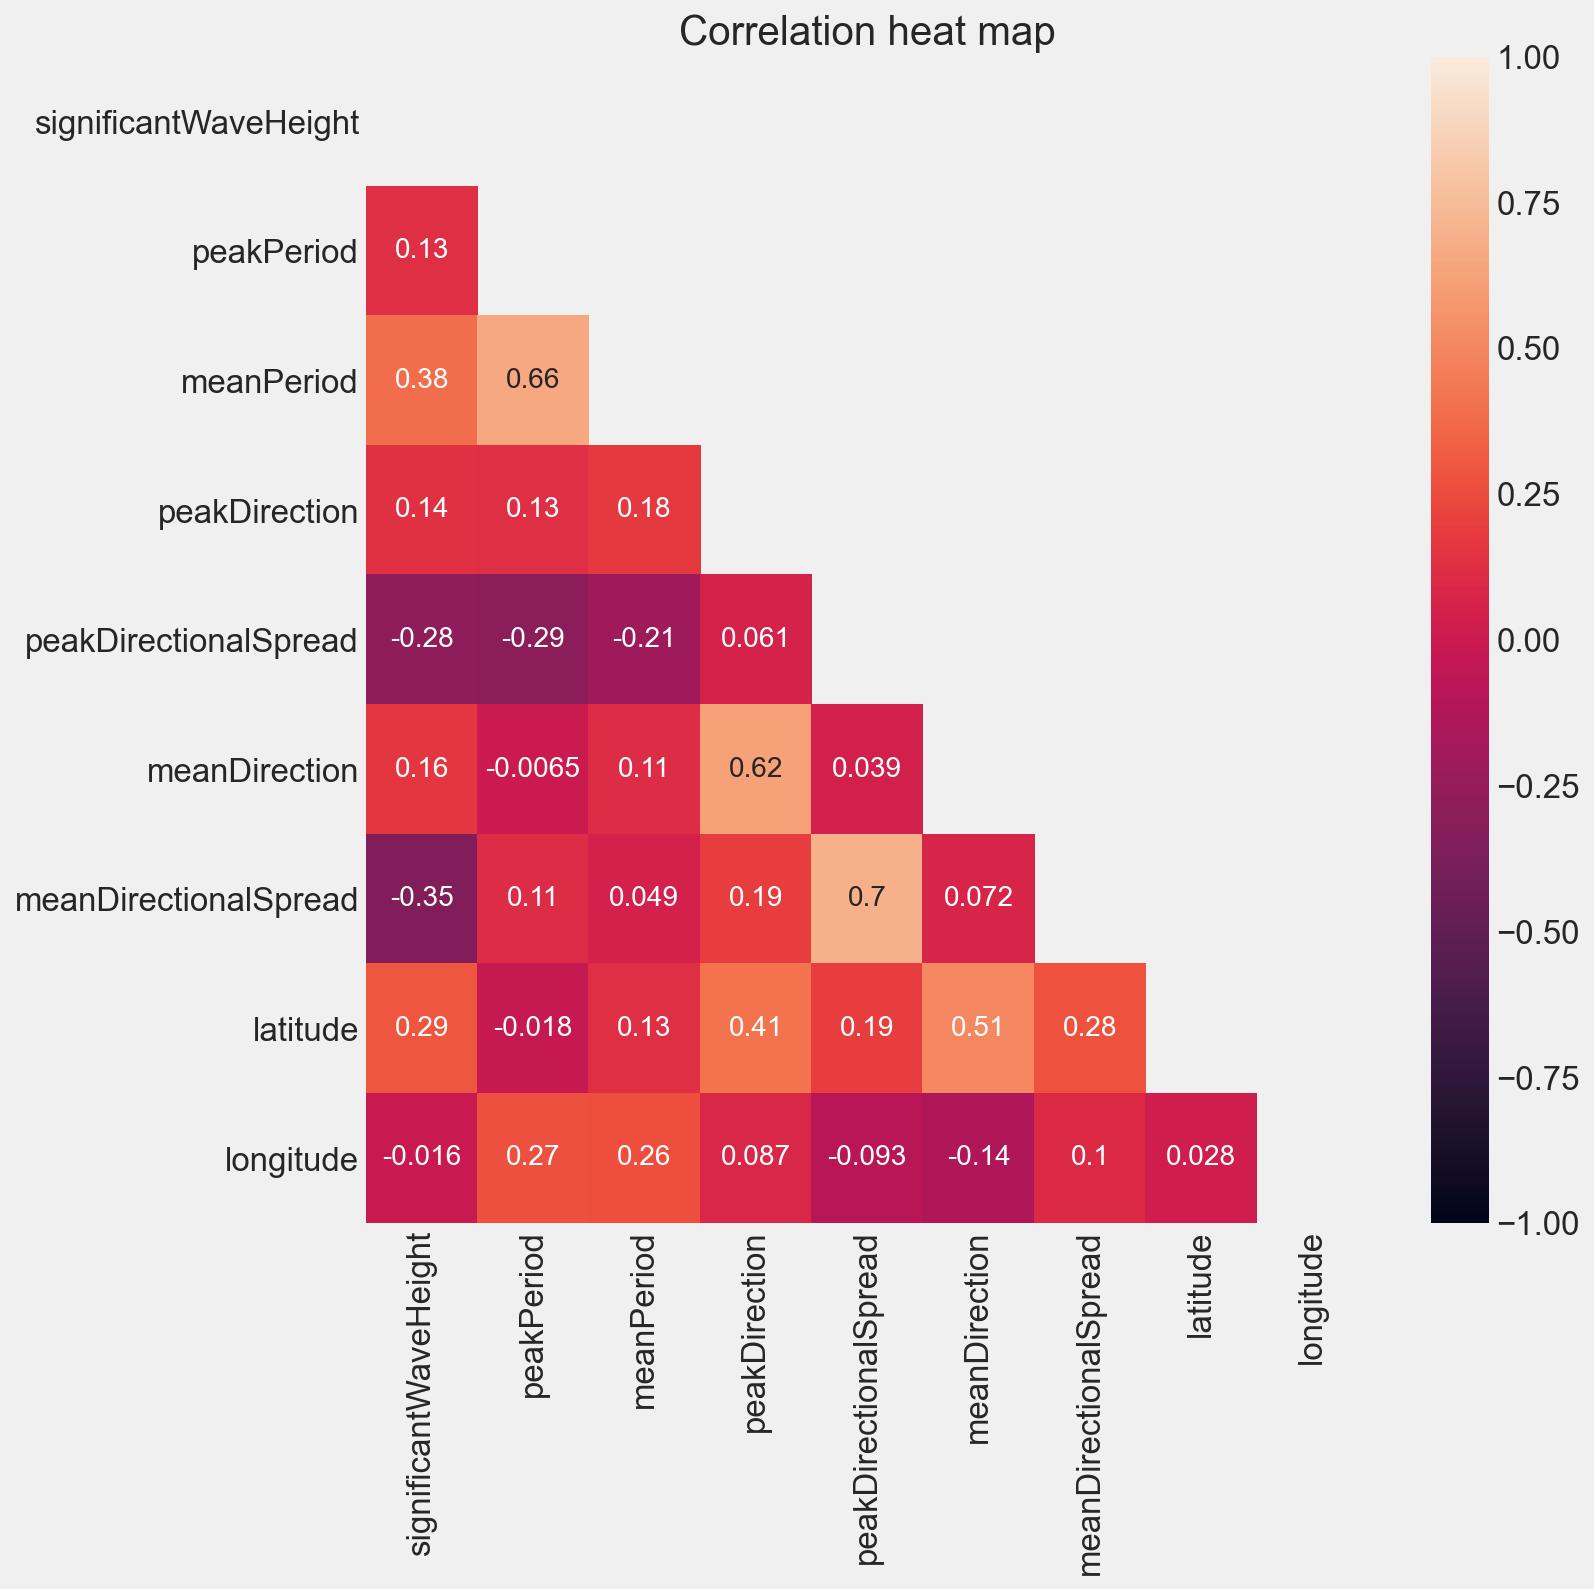

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
mask = np.zeros_like(original_data[original_data.columns[1:]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(original_data[original_data.columns[1:]].corr(), mask=mask, annot=True, vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation heat map')
plt.show()

In [6]:
def heading(cell):
    heading = round(Geodesic.WGS84.Inverse(cell[9], cell[10], cell[11], cell[12])['azi1'], 2)
    if heading < 0:
        return heading + 360
    else:
        return heading

def distance(cell):
    return round(Geodesic.WGS84.Inverse(cell[9], cell[10], cell[11], cell[12])['s12'], 2)

In [7]:
first_buoy_data = original_data[original_data['spotId'] == 0]
first_buoy_data['next_latitude'] = first_buoy_data['latitude'].shift(-1)
first_buoy_data['next_longitude'] = first_buoy_data['longitude'].shift(-1)

first_buoy_data['heading'] = first_buoy_data.apply(heading, axis=1)
first_buoy_data['distance'] = first_buoy_data.apply(distance, axis=1).shift(1)

In [8]:
for buoy in original_data['spotId'].unique()[1:]:
    subs_buoy_data = original_data[original_data['spotId'] == buoy]
    subs_buoy_data['next_latitude'] = subs_buoy_data['latitude'].shift(-1)
    subs_buoy_data['next_longitude'] = subs_buoy_data['longitude'].shift(-1)
    subs_buoy_data['heading'] = subs_buoy_data.apply(heading, axis=1)
    subs_buoy_data['distance'] = subs_buoy_data.apply(distance, axis=1).shift(1)
    first_buoy_data = pd.concat([first_buoy_data, subs_buoy_data], ignore_index=True)

In [9]:
first_buoy_data.drop(['next_latitude', 'next_longitude'], axis=1, inplace=True)

In [10]:
first_buoy_data.to_csv('../data-sources/forecasting-floats/cleaned-buoy-data.csv', index=False)

In [11]:
buoy_data = pd.read_csv('../data-sources/forecasting-floats/cleaned-buoy-data.csv')

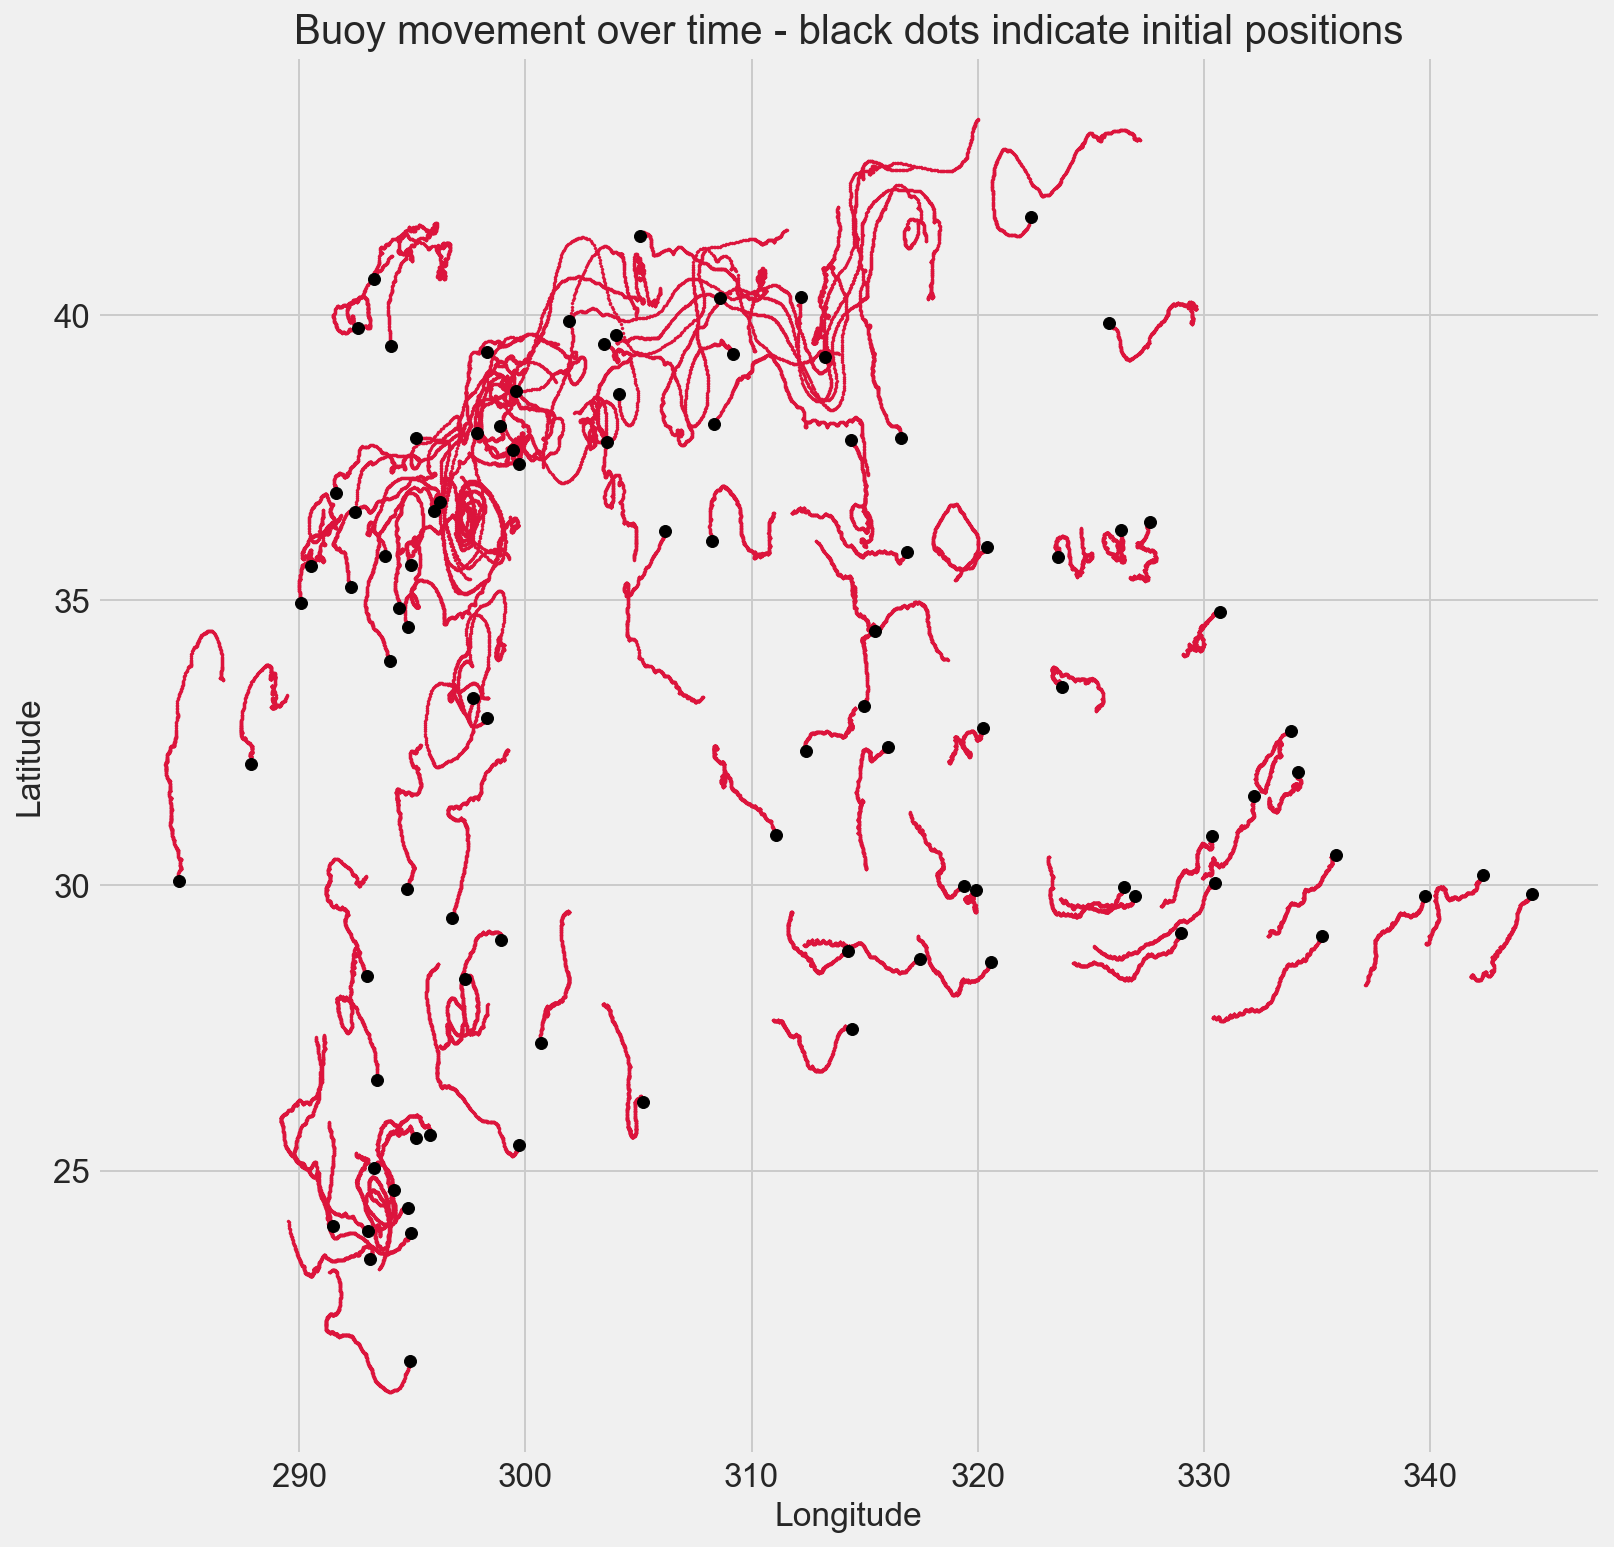

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=buoy_data, x='longitude', y='latitude', c=['crimson'], edgecolor=None, s=2.5, ax=ax)
for buoy in buoy_data['spotId'].unique():
    sns.scatterplot(data=buoy_data[buoy_data['spotId'] == buoy][:1],
                        x='longitude', y='latitude', c=['black'], edgecolor=None, ax=ax)
ax.set_title('Buoy movement over time - black dots indicate initial positions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [13]:
cir_corrs = []
for buoy in buoy_data['spotId'].unique():
    cir_corrs.append(circcorrcoef(buoy_data[buoy_data['spotId'] == buoy]['heading'][0: -1].values*u.deg,
                     buoy_data[buoy_data['spotId'] == buoy]['meanDirection'][0: -1].values*u.deg).value)

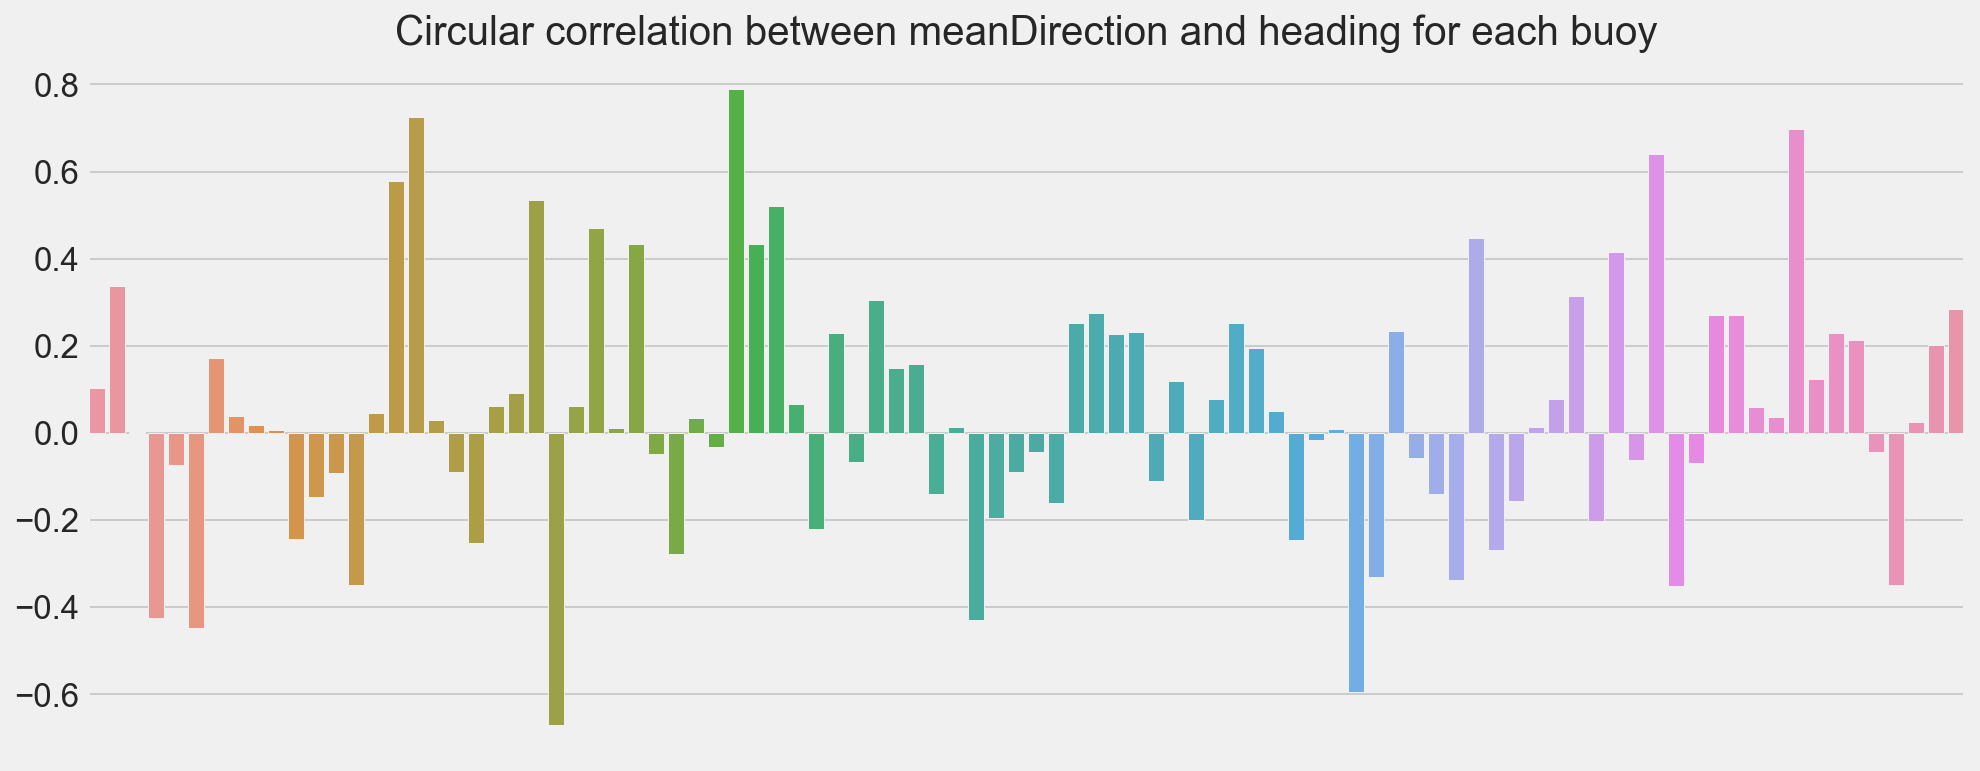

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))
f1 = sns.barplot(y=cir_corrs, x=buoy_data['spotId'].unique())
f1.set(xlabel=None)
f1.set(xticklabels=[])
ax.set_title('Circular correlation between meanDirection and heading for each buoy')
plt.show()

In [15]:
cir_corrs = []
for buoy in buoy_data['spotId'].unique():
    cir_corrs.append(circcorrcoef(buoy_data[buoy_data['spotId'] == buoy]['heading'][0: -1].values*u.deg,
                     buoy_data[buoy_data['spotId'] == buoy]['peakDirection'][0: -1].values*u.deg).value)

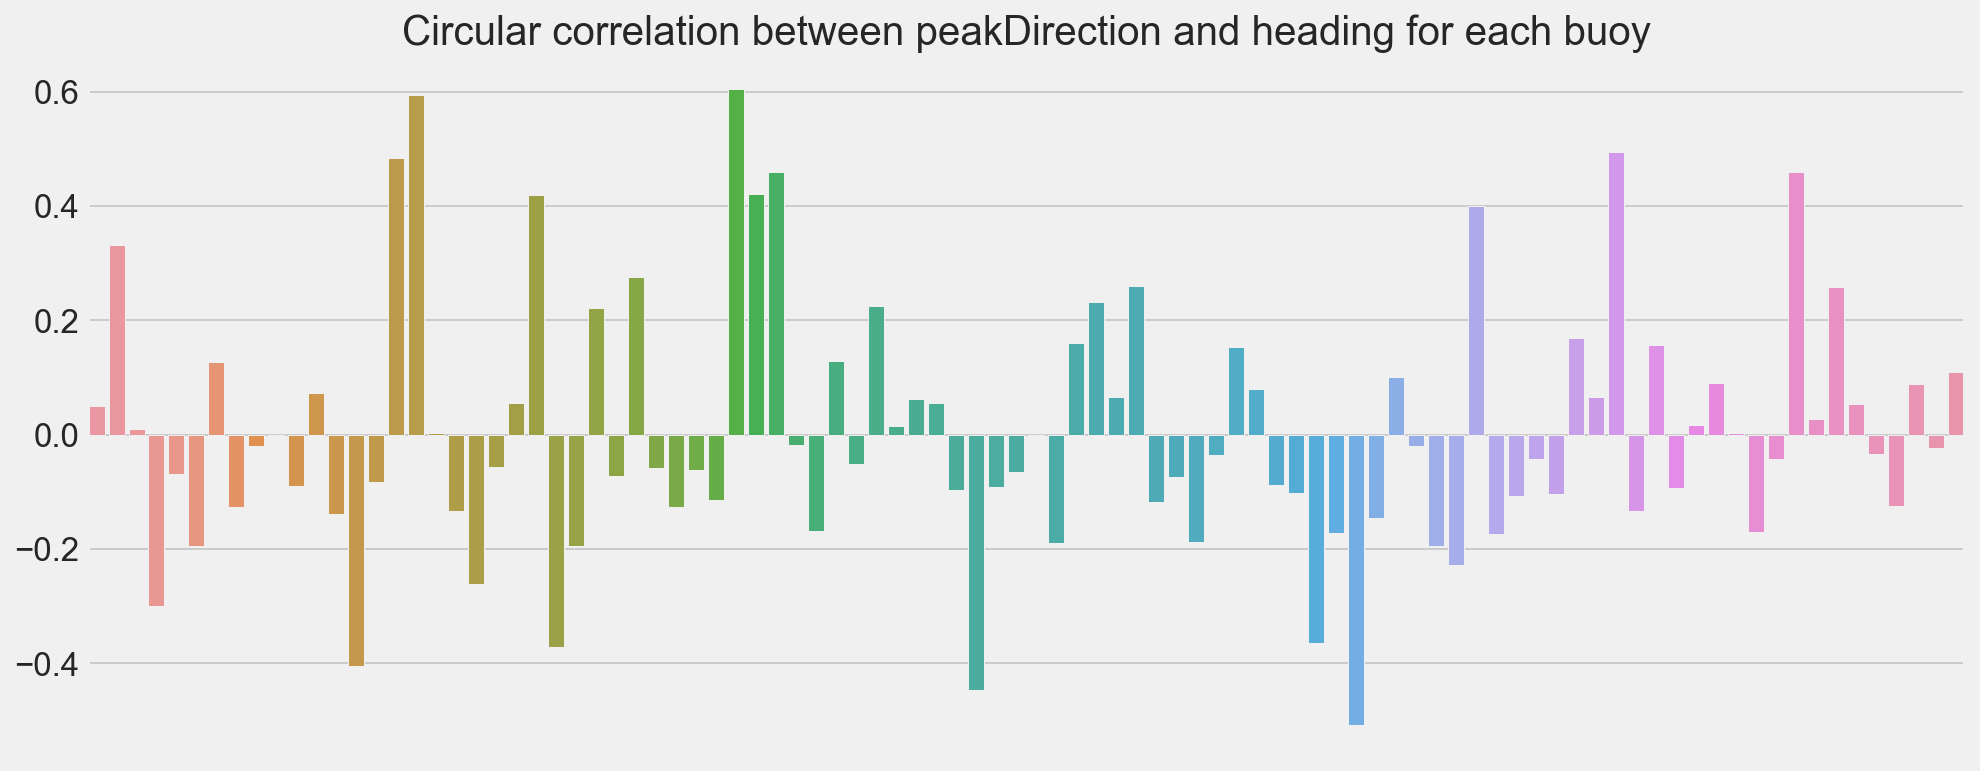

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
f1 = sns.barplot(y=cir_corrs, x=buoy_data['spotId'].unique())
f1.set(xlabel=None)
f1.set(xticklabels=[])
ax.set_title('Circular correlation between peakDirection and heading for each buoy')
plt.show()